This program generates required figures

In [2]:
# Importing modules
import pandas as pd
#import seaborn as sns    #need to comment this for networkx plots to show border
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib.colors as mcolors
#import networkx as nx
import numpy as np


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Fig 1: Trendline of the number of papers over time

In [1]:
df_themes_numpapers = pd.read_csv('/results/df_themes_numpapers.csv')

There were  {total_papers} papers in total
There were  {avg_papers} papers in Average


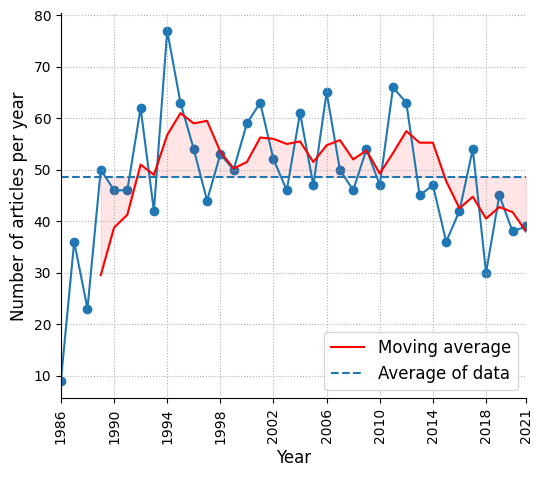

In [11]:
#get average of the number of papers 
yrs = df_themes_numpapers['Year']
numpapers = df_themes_numpapers['numpapers']
total_papers = sum(numpapers)
avg_papers = round(sum(numpapers)/len(numpapers),2)  #average number of papers throughout the period

#get moving average
#compute moving average
x = list(range(0,36))
y = numpapers
window = 4
average_y = []   #moving average vector
for ind in range(len(y) - window + 1):
      average_y.append(np.mean(y[ind:ind+window]))

#         #add NaNs at the begining
for ind in range(window - 1):
     average_y.insert(0, np.nan)
        
        
#plot figure
plt.figure(figsize=(6, 5))

plt.plot(yrs, numpapers)
plt.scatter(yrs, numpapers)
plt.plot(yrs, average_y, 'r-', label='Moving average')
plt.axhline(y=avg_papers, linestyle = '--', label = 'Average of data')
plt.fill_between(yrs, average_y, avg_papers, color='r', alpha=0.1)
plt.grid(linestyle=':')
#plt.ylim(6,81)
plt.xlim(1986,2021)
plt.xticks([1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2021], rotation='vertical')
plt.ylabel("Number of articles per year", fontsize=12) 
plt.xlabel("Year", fontsize=12) 
plt.legend(loc = 'lower right', fontsize=12)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

print("There were  {total_papers} papers in total")
print("There were  {avg_papers} papers in Average")
plt.savefig('/images/papers_trend_plot.pdf', dpi=300,bbox_inches='tight');
plt.show();

## Fig 2: Stream plot of the themes

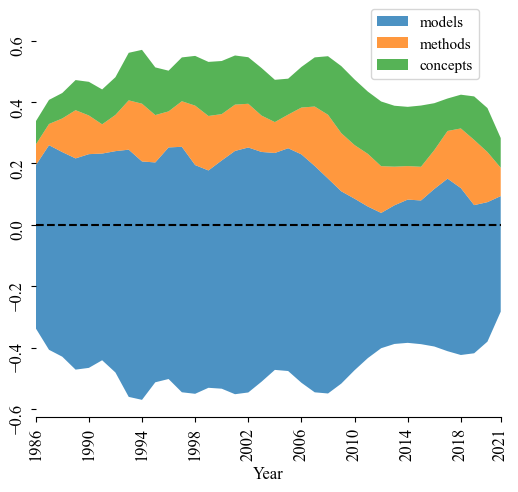

In [102]:
#define a smoothing function to smooth data
def gaussian_smooth(x, y, sd):
    weights = np.array([stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(1)
    return (weights * y).sum(1)

#create a dictionary with smoothed data
dic_themes = {
    'models': gaussian_smooth(yrs, df_themes_numpapers['models'].tolist(), 1), 
     'methods': gaussian_smooth(yrs, df_themes_numpapers['methods'].tolist(), 1), 
     'concepts': gaussian_smooth(yrs, df_themes_numpapers['concepts'].tolist(), 1) 
}
x_ticks = [str(x) for x in yrs]

#plot figure
fig, ax = plt.subplots(figsize=(6,5))
ax.stackplot(yrs.tolist(), dic_themes.values(), baseline= "sym",
             labels=dic_themes.keys(), alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.tick_params(rotation=90)
#ax.set_xticklabels(yrs, x_ticks, rotation=45)

#ax.set(yticklabels=[])  
plt.xlim(1986,2021)
plt.xticks([1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2021], rotation='vertical')
ax.legend(loc='upper right',fontsize=11, bbox_to_anchor=(0.97, 1.08))
#plt.yticks([])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
# #ax.set_ylabel('Proportion')
ax.axhline(0, color="black", ls="--");

fig.savefig('/images/themes_stream_trend_plot.pdf', dpi=300,bbox_inches='tight')

plt.show()

## Fig 3: Heatmap of keywords

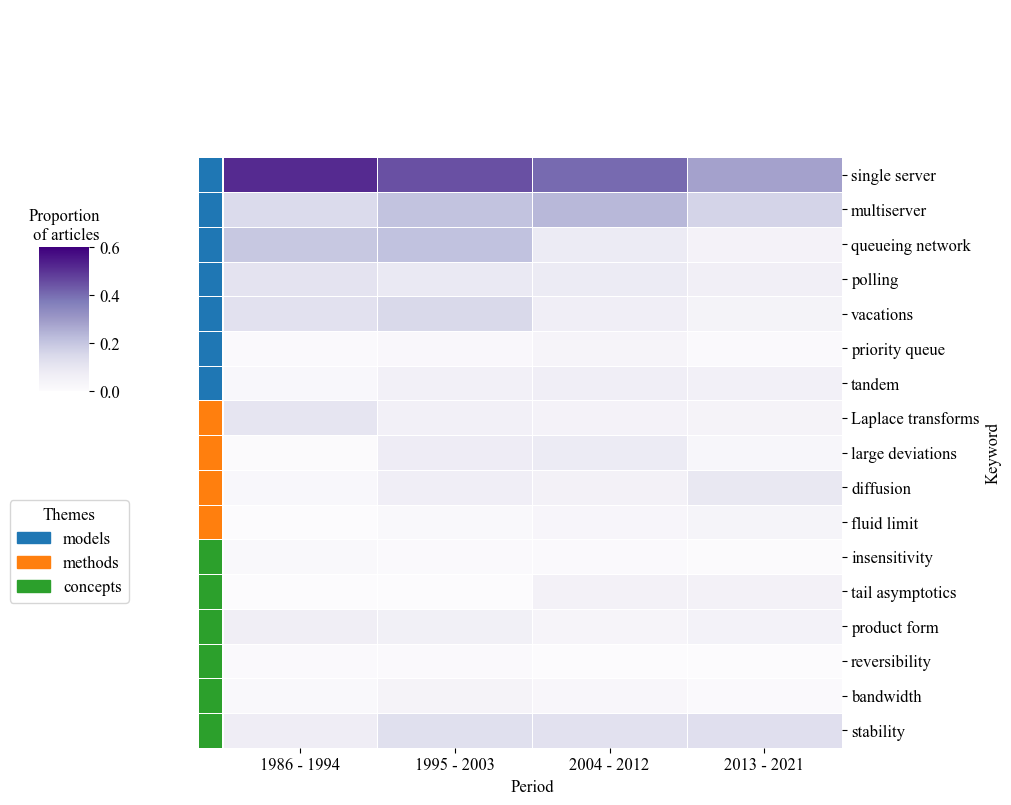

In [104]:
df_periods = pd.read_csv('/results/df_keywords.csv')
#df_periods
keywords = df_periods['keywords']
themes = df_periods["themes"]
my_palette = dict(zip(themes.unique(), ["tab:blue","tab:orange","tab:green"]))  #{1: 'blue', 2: 'orange', 3: 'green'}
row_colors = list(themes.map(my_palette))

df_periods = df_periods.set_index('keywords') #do this once


g = sns.clustermap(df_periods.iloc[:,0:4],#.reset_index(drop=True), 
                   #robust = True,
                   cmap="Purples", vmin=0, vmax=0.6, 
                   #metric="correlation",method="single", 
                   col_cluster=False, row_cluster = False,
                   cbar_pos=(0.02, 0.5, 0.05, 0.18),
                   linewidths=.5,
                  # annot= True,
                   row_colors=row_colors, figsize = (10,8))

g.cax.set_title("Proportion\n of articles", fontsize = 12)
ax = g.ax_heatmap
ax.set_xlabel("Period", fontsize = 12)
ax.set_ylabel("Keyword", fontsize=12)  #use this if row_colors didnot work

#ax.set_yticklabels(labels= list(keywords), rotation = 360)

model_patch = mpatches.Patch(color='tab:blue', label='models')
method_patch = mpatches.Patch(color='tab:orange', label='methods')
concept_patch = mpatches.Patch(color='tab:green', label='concepts')
plt.legend(handles=[model_patch, method_patch, concept_patch], bbox_to_anchor=(0.05, 0.3), 
           bbox_transform=plt.gcf().transFigure, loc='center', fontsize = 12,
          title = 'Themes')


plt.savefig'/images/heatmap_keywords_period.pdf', dpi=300,bbox_inches='tight');

# plt.show()

## Fig 5: network of co-occurance words

In [2]:
df_occurance = pd.read_csv(path + '/results/df_co_occurance.csv')
df_occurance ['bigram'] = df_occurance.bigram.apply(lambda x: eval(x))
df_occurance.dtypes


In [3]:
df_occurance_period = df_occurance.iloc[:,[0,i]]   #select columns 0 and i


In [4]:
#need this list to set colors and titles 
lst_models = ['single server', 'multiserver','queueing network','polling','vacations','priority queue','tandem']
lst_methods = ['Laplace transforms', 'large deviations', 'diffusion', 'fluid limit']
lst_concepts = ['insensitivity','tail asymptotics','product form','reversibility','bandwidth','stability']
period_ranges = ['1986 - 1994',  '1995 - 2003', '2004 - 2012', '2013 - 2021']


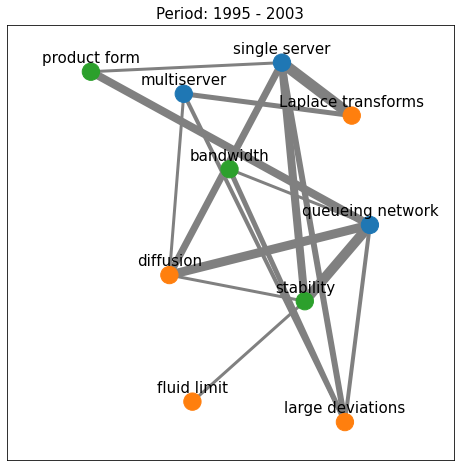

In [20]:
#create color pallate based on themes 

# Create dictionary of bigrams and their counts
i = 2    #start  i from 1
df_occurance_period = df_occurance.iloc[:,[0,i]]   #select columns 0 and i
df_occurance_period = df_occurance_period.loc[df_occurance_period.iloc[:,1]>=3]  #select non-zero rows

# #create a dictionary 
d = df_occurance_period.set_index('bigram').T.to_dict('records')

# # Create network plot 
G = nx.Graph()

# # Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 1))
    #print(k[0],k[1],v)

G

#define node colors
color_map = []
for node in G:
        if node in lst_models:
            color_map.append('tab:blue')
        elif node in lst_methods:
            color_map.append('tab:orange')
        else:
            color_map.append('tab:green')
        
#plot fig
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(G,  k= 14, iterations =5, scale =50, center = (50,50))
nx.draw_networkx(G, pos, 
                 font_size=16,
                 #width=3,
                 edge_color='grey',
                 node_color = color_map,
                 with_labels = False,
                 #font_weight='bold',
                 ax=ax)

#set edge width based on wight
for edge in G.edges(data = 'weight'):
    nx.draw_networkx_edges(G, pos,
                           edgelist = [edge],
                          width = edge[2],
                          edge_color='grey')
    
# Create offset labels
for key, value in pos.items():
   # x, y = value[0]+.1, value[1]+ 2
    x, y = value[0]+ 0, value[1]+ 2
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=15)

#set x and y margins 
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.30
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.box(True)

#create ledgends based on themes
legend_elements = [Line2D([0], [0], linestyle='none', marker = 'o', color='tab:blue',  label='models',
                         markerfacecolor='tab:blue', markersize=12),
                   Line2D([0], [0], linestyle='none', marker='o', color='tab:orange', label='methods',
                          markerfacecolor='tab:orange', markersize=12),
                   Line2D([0], [0], linestyle='none', marker = 'o', color='tab:green',  label='concepts',
                         markerfacecolor='tab:green', markersize=12)]

#ax.legend(handles=legend_elements, loc='upper right', fontsize = 10)

#set title 
title = period_ranges[i-1]
ax.set_title('Period: ' + str(title), x = 0.5, y=1.0, fontsize = 15)

plt.savefig(path + '/images/co_occurance_period'+ str(i) + '_plot.pdf',
                              dpi=300,bbox_inches='tight')
    
plt.show()

## Fig 6: Distribution of Topic proportions

In [4]:
df_counts = pd.read_csv(path + '/results/df_topics.csv')

In [7]:
#compute proportions
Total = df_counts['Count'].sum()  
percentage = (df_counts['Count'] / Total) * 100
percentage = list(percentage[1:12])


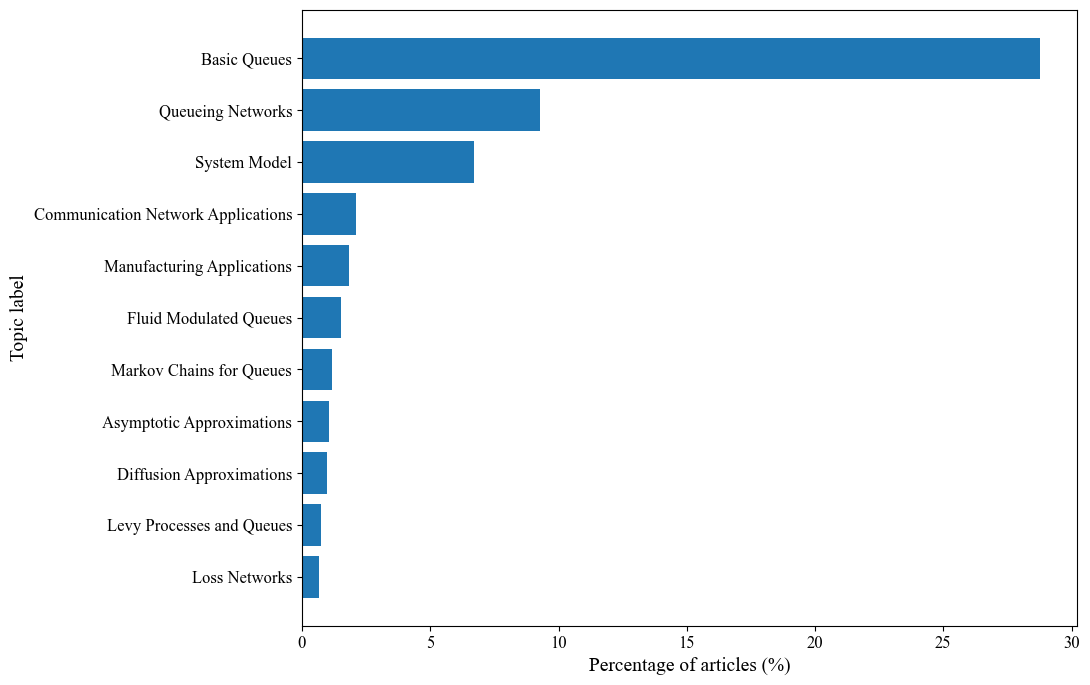

In [9]:
# define the topics 
lst2 = ['Basic Queues', 'Queueing Networks', 'System Model', 'Communication Network Applications', 
        'Manufacturing Applications', 'Fluid Modulated Queues', 'Markov Chains for Queues', 
        'Asymptotic Approximations', 'Diffusion Approximations','Levy Processes and Queues', 
        'Loss Networks']

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
 
fig, ax = plt.subplots(figsize=(10, 8))

# # creating the bar plot
# ax.barh(lst2, proportion, align='center', color ='tab:blue') # , 
ax.barh(lst2, percentage, align='center', color ='tab:blue') # ,
ax.invert_yaxis() 
#ax.set_xlabel('Proportion of articles', fontsize = 14)
ax.set_xlabel('Percentage of articles (%)', fontsize = 14)
ax.set_ylabel('Topic label', fontsize = 14)

plt.savefig(path + '/images/topics_proportion.pdf', dpi=300,bbox_inches='tight')

plt.show()

## Fig 7: Heat map of Topics over time

In [5]:
# number of papers per period 
period1_papers = sum(list(numpapers[0:9])) 
period2_papers = sum(list(numpapers[9:18])) 
period3_papers = sum(list(numpapers[18:27])) 
period4_papers = sum(list(numpapers[27:40])) 

In [6]:
df_topics_period_prop = pd.read_csv(path + '/results/df_topics_period.csv')
#df_topics_period_prop.columns

df_topics_period_prop.iloc[:,1] = ((df_topics_period_prop.iloc[:,1]/period1_papers)*100).round(2)
df_topics_period_prop.iloc[:, 2] = ((df_topics_period_prop.iloc[:,2]/period2_papers)*100).round(2)
df_topics_period_prop.iloc[:, 3] = ((df_topics_period_prop.iloc[:,3]/period3_papers)*100).round(2)
df_topics_period_prop.iloc[:, 4] = ((df_topics_period_prop.iloc[:,4]/period4_papers)*100).round(2)

df_topics_period_prop = df_topics_period_prop.set_index('Topic') #do this once

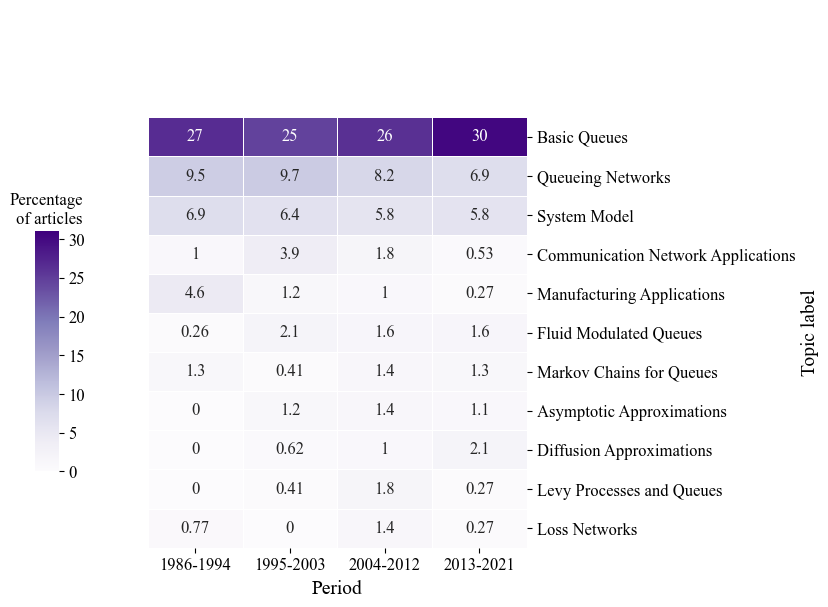

In [96]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
g = sns.clustermap(df_topics_period_prop.iloc[:,0:4],               
                   #robust = True,
                   cmap="Purples", vmin=0, vmax=31, 
                   #metric="correlation",method="single", 
                   col_cluster=False, row_cluster = False,
                   cbar_pos=(0.0, .2, .03, .4),
                   linewidths=.5,
                   #row_colors=row_colors, 
                   annot= True, 
                   #fmt="d",
                   figsize = (8,6))
g.cax.set_title("Percentage\n of articles", fontsize = 12)
ax = g.ax_heatmap
ax.set_xlabel("Period", fontsize = 14)
ax.set_ylabel('Topic label', fontsize = 14)
#x.set_ylabel("Topic name", fontsize = 12)
#heatmap_plot.cax.set_title("my cbar label")

plt.savefig('/images/topics_overperiods_prop.pdf', dpi=300,bbox_inches='tight');

plt.show()
#df_topics_period